In [2]:
import os
import pandas as pd
import requests
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

import torch
import torch.nn.functional as F
from torch import nn
from torch.nn.utils import prune
from torch import optim
from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18, resnet50, vgg16
from torchvision.models.feature_extraction import create_feature_extractor

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
SEED = 42
RNG = torch.Generator().manual_seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

Running on device: CUDA


In [3]:
import ssl

# Create an unverified SSL context
ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
# download and pre-process CIFAR10
normalize = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

train_set = torchvision.datasets.CIFAR10(
    root="../example notebooks/data", train=True, download=False, transform=normalize
)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=1)

# we split held out data into test and validation set
held_out = torchvision.datasets.CIFAR10(
    root="../example notebooks/data", train=False, download=False, transform=normalize
)
test_set, val_set = torch.utils.data.random_split(held_out, [0.5, 0.5], generator=RNG)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=1)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=1)

# download the forget and retain index split
local_path = "../example notebooks/forget_idx.npy"
# if not os.path.exists(local_path):
#     response = requests.get(
#         "https://storage.googleapis.com/unlearning-challenge/" + local_path
#     )
#     open(local_path, "wb").write(response.content)
forget_idx = np.load(local_path)

# construct indices of retain from those of the forget set
forget_mask = np.zeros(len(train_set.targets), dtype=bool)
forget_mask[forget_idx] = True
retain_idx = np.arange(forget_mask.size)[~forget_mask]

# split train set into a forget and a retain set
forget_set = torch.utils.data.Subset(train_set, forget_idx)
retain_set = torch.utils.data.Subset(train_set, retain_idx)

forget_loader = torch.utils.data.DataLoader(
    forget_set, batch_size=128, shuffle=False, num_workers=1
)
# retain_loader = torch.utils.data.DataLoader(
#     retain_set, batch_size=128, shuffle=True, num_workers=1, generator=RNG
# )

In [5]:
retain_loader = torch.utils.data.DataLoader(
    retain_set, batch_size=128, shuffle=False, num_workers=1
)

In [6]:
local_path = "../example notebooks/weights/weights_resnet18_cifar10.pth"
if not os.path.exists(local_path):
    response = requests.get(
        "https://storage.googleapis.com/unlearning-challenge/weights_resnet18_cifar10.pth"
    )
    open(local_path, "wb").write(response.content)

weights_pretrained = torch.load(local_path, map_location=DEVICE) #43Mbs

# load model with pre-trained weights
model = resnet18(weights=None, num_classes=10)
model.load_state_dict(weights_pretrained)
model.to(DEVICE)
model.eval();

## Feat extraction

In [7]:
feat_extractor = create_feature_extractor(model, {'avgpool': 'feat1'})

In [8]:
# Retain feats
data = np.empty((len(retain_loader.dataset), 513), dtype=object)
idx = 0

for sample in retain_loader:

    inputs = sample[0].to(DEVICE)
    target = sample[1]

    with torch.no_grad():
        outputs = feat_extractor(inputs)['feat1']
        feats = torch.flatten(outputs, start_dim=1)

    for i in range(len(target)):
        data[idx] = [str(idx)] + feats[i].cpu().numpy().tolist()
        idx +=1

columns = ['ID'] + [f'feat_{i}' for i in range(512)]
feats_retain_df = pd.DataFrame(data, columns=columns)

In [9]:
feats_retain_df

,ID,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,...,feat_502,feat_503,feat_504,feat_505,feat_506,feat_507,feat_508,feat_509,feat_510,feat_511
0,0,0.211599,1.406087,0.523785,0.013362,0.000466,0.000186,0.00005,0.000586,0.132151,...,0.000074,0.205793,0.000296,0.000491,1.097302,0.481894,0.698237,0.0005,0.000031,0.317414
1,1,0.273515,1.314863,0.48362,0.0,0.000466,0.000186,0.00005,0.002497,0.074057,...,0.0064,0.162691,0.000296,0.000491,0.998929,0.4274,0.707737,0.0005,0.000031,0.48738
2,2,0.000032,0.666647,0.000175,0.0,0.000466,0.175322,0.00005,0.026575,0.000086,...,0.62746,0.046386,0.237074,0.234482,0.000122,0.037771,0.17611,0.168142,0.167454,0.024085
3,3,0.015453,0.000545,0.000175,0.005988,0.359371,0.431049,0.336963,0.005847,0.000086,...,0.119365,0.000272,0.214024,0.000491,0.000122,0.007893,0.000437,0.0005,0.01024,0.00488
4,4,0.033434,0.000545,0.000175,0.00987,0.486044,0.293676,0.460867,0.003692,0.000086,...,0.007483,0.000272,0.134542,0.051431,0.000122,0.000118,0.000437,0.0005,0.109125,0.37077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,44995,0.033827,0.000545,0.000175,0.026604,0.334275,0.33089,0.306893,0.004603,0.000086,...,0.061199,0.000272,0.19857,0.009602,0.000122,0.013841,0.000437,0.0005,0.000031,0.220226
44996,44996,0.123089,0.000545,0.309443,0.016996,0.000466,0.164683,0.063864,0.00632,0.117461,...,0.350877,0.210456,0.404631,0.000491,0.401511,0.215515,0.356266,0.100934,0.122237,0.222575
44997,44997,0.218727,0.733207,0.489559,0.0,0.000466,0.000186,0.00005,0.002666,0.1159,...,0.000074,0.212849,0.000296,0.000491,0.486716,0.096506,0.546069,0.0005,0.000031,0.693718
44998,44998,0.020037,0.000545,0.000175,0.0,0.287762,0.255987,0.279541,0.004926,0.000086,...,0.083441,0.000272,0.237738,0.000491,0.000122,0.000118,0.000437,0.0005,0.000031,0.32096


In [10]:
# Forget feats
data = np.empty((len(forget_loader.dataset), 513), dtype=object)
idx = 0

for sample in forget_loader:

    inputs = sample[0].to(DEVICE)
    target = sample[1]

    with torch.no_grad():
        outputs = feat_extractor(inputs)['feat1']
        feats = torch.flatten(outputs, start_dim=1)

    for i in range(len(target)):
        data[idx] = [target[i].item()] + feats[i].cpu().numpy().tolist()
        idx +=1

columns = ['target'] + [f'feat_{i}' for i in range(512)]
feats_forget_df = pd.DataFrame(data, columns=columns)

In [35]:
# def compute_max_similarity(features_retain, features_forget, batch_size=1024):
#     max_similarity = np.empty(features_retain.shape[0])
#     for i in range(0, features_retain.shape[0], batch_size):
#         batch_features_retain = features_retain[i:i+batch_size]
#         if similarity_metric=='euclidean':
#             similarity_matrix = euclidean_distances(batch_features_retain, features_forget)
#             max_similarity[i:i+batch_size] = np.min(similarity_matrix, axis=1)
#         elif similarity_metric=='cosine':
#             similarity_matrix = cosine_similarity(batch_features_retain, features_forget)
#             max_similarity[i:i+batch_size] = np.max(similarity_matrix, axis=1)
#         return max_similarity
    
similarity_metric = 'cosine'
similarity_pct = 0.05

features_retain = feats_retain_df.iloc[:,1:].values
features_forget = feats_forget_df.iloc[:,1:].values

# Compute max similarity
max_similarity = np.empty(features_retain.shape[0])
for i in range(0, features_retain.shape[0], 512):
    batch_features_retain = features_retain[i:i+512]
    if similarity_metric=='euclidean':
        similarity_matrix = euclidean_distances(batch_features_retain, features_forget)
        max_similarity[i:i+512] = np.min(similarity_matrix, axis=1)
        top_X_pct_idx = np.argsort(max_similarity)[:int(similarity_pct * len(max_similarity))]
    elif similarity_metric=='cosine':
        similarity_matrix = cosine_similarity(batch_features_retain, features_forget)
        max_similarity[i:i+512] = np.max(similarity_matrix, axis=1)
        top_X_pct_idx = np.argsort(max_similarity)[-int(similarity_pct * len(max_similarity)):]

# Get X% of data points
similar_df = feats_retain_df.iloc[top_X_pct_idx]
similar_ids_set = set(top_X_pct_idx)

In [36]:
include_indices = [i for i,data_id in enumerate(feats_retain_df['ID']) if data_id not in similar_ids_set]
filtered_dataset = Subset(retain_loader.dataset, include_indices)
loader2 = DataLoader(filtered_dataset, batch_size=128, shuffle=False)

In [47]:
next(iter(loader2))

[tensor([[[[ 0.5562,  0.0134, -0.3936,  ..., -0.6650, -0.7426, -0.8977],
           [ 0.2848,  0.3817, -0.0060,  ..., -0.5681, -0.9364, -1.0527],
           [ 0.2848,  0.2654, -0.1998,  ..., -0.8977, -1.1109, -1.1303],
           ...,
           [ 0.9633,  0.5950,  0.5562,  ..., -1.6149, -1.2466, -0.6263],
           [ 0.7694,  0.5950,  0.6531,  ..., -0.4324, -0.0447,  0.1104],
           [ 0.7307,  0.6338,  0.7307,  ...,  0.3430,  0.3430,  0.3430]],
 
          [[ 1.0628,  0.2761, -0.3729,  ..., -0.5499, -0.6482, -0.8252],
           [ 0.7284,  0.5908,  0.0401,  ..., -0.4712, -0.8449, -0.9826],
           [ 0.6301,  0.4531, -0.1566,  ..., -0.8056, -1.0416, -1.0612],
           ...,
           [ 0.8661,  0.6104,  0.7284,  ..., -1.7496, -1.3759, -0.7859],
           [ 0.6104,  0.5711,  0.7481,  ..., -0.5892, -0.1762, -0.0386],
           [ 0.4924,  0.4924,  0.6498,  ...,  0.1974,  0.2171,  0.1974]],
 
          [[ 1.4270,  0.4320, -0.3679,  ..., -0.8362, -0.8362, -0.8557],
           [ 

In [37]:
del similar_ids_set
del include_indices
del filtered_dataset

# Plots

In [38]:
from sklearn.manifold import TSNE

In [43]:
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=300)
tsne_results = tsne.fit_transform(features_forget)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.002s...
[t-SNE] Computed neighbors for 5000 samples in 0.556s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.676117
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.829361
[t-SNE] KL divergence after 300 iterations: 3.025418


In [44]:
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=300)
tsne_results2 = tsne.fit_transform(similar_df.iloc[:,1:].values)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 2250 samples in 0.002s...
[t-SNE] Computed neighbors for 2250 samples in 0.183s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2250
[t-SNE] Computed conditional probabilities for sample 2000 / 2250
[t-SNE] Computed conditional probabilities for sample 2250 / 2250
[t-SNE] Mean sigma: 0.356182
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.431427
[t-SNE] KL divergence after 300 iterations: 2.388801


In [45]:
import seaborn as sns
import pandas as pd

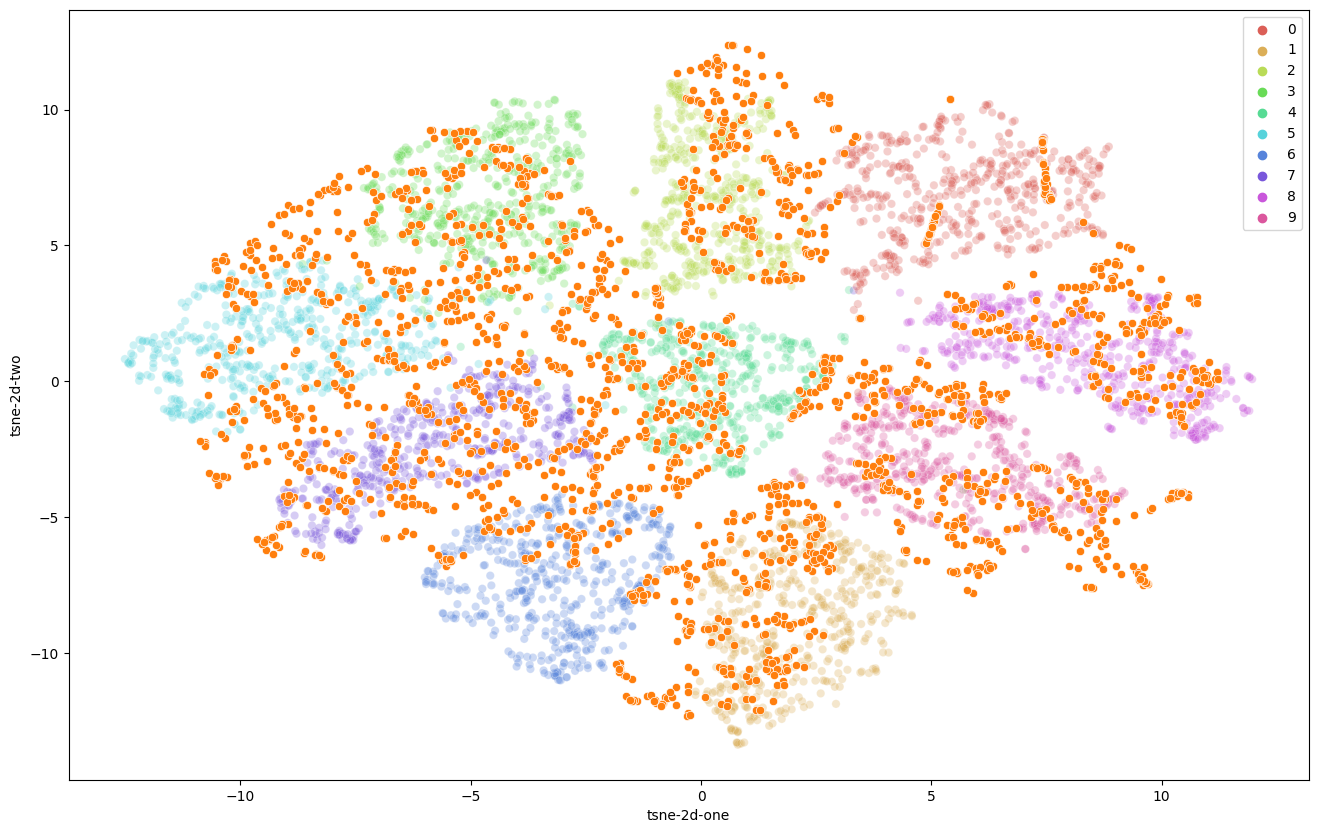

In [46]:
df_subset = pd.DataFrame()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset['y'] = feats_forget_df['target']

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)

df_subset2 = pd.DataFrame()
df_subset2['tsne-2d-one'] = tsne_results2[:,0]
df_subset2['tsne-2d-two'] = tsne_results2[:,1]
df_subset2['y'] = similar_df['ID']

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    # hue="y",
    # palette=sns.color_palette("light:black", 10),
    data=df_subset2,
    legend="full",
    alpha=1
)


plt.show()